In [1]:
import pandas as pd

In [3]:
df=pd.read_csv("/config/workspace/machine datasets/online_shoppers_intention.csv")

In [4]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.metrics import classification_report

<Axes: xlabel='Revenue'>

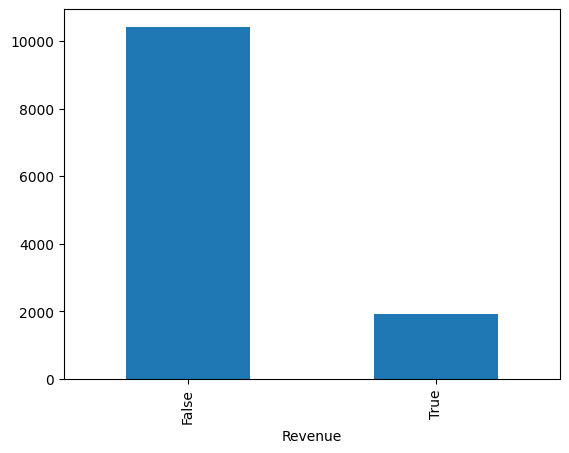

In [6]:
def preprocessing(df,columns):
    df.dropna(inplace=True) 
    df.replace(['Returning_Visitor', 'New_Visitor','Other'],[1,2,3], inplace=True)
    df.replace(['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct','Nov','Dec'],[1,2,3,4,5,6,7,8,9,10,11,12],inplace=True)
    if columns!=[]: 
        df=df[columns]
    return df

def Split(df):
    X = df.drop('Revenue', axis=1)
    y = df['Revenue']
    obj_escalar = StandardScaler()
    X_standardization = obj_escalar.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    return X_train, X_test, Y_train, Y_test
 
df=preprocessing(df,[])
X_train, X_test, Y_train, Y_test=Split(df)
df['Revenue'].value_counts().plot.bar()

In [7]:
# We observe that the data are imbalanced. There is a lot more 'Revenue = False' observations than 'Revenue = True'. We will therefore have to take it into account in our models.

In [8]:
"""
> BASELINE LOGISTIC REGRESSION
The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
Cfloat, default=1.0 Inverse of regularization strength; must be a positive float --> smaller values specify stronger regularization.
"""

'\n> BASELINE LOGISTIC REGRESSION\nThe “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).\nCfloat, default=1.0 Inverse of regularization strength; must be a positive float --> smaller values specify stronger regularization.\n'

In [9]:
model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train, Y_train)
y_pred=model1.predict(X_test)
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_pred),3)))  
print("\nRecall\t{}".format(round(metrics.recall_score(Y_test, y_pred),3)))  
model1.get_params()


Accuracy	0.858

Recall	0.74


{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [10]:
parametres = {"C": [0.001, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.1]}
model1_gs = GridSearchCV(model1, param_grid=parametres,
                         cv = 10, scoring='accuracy')
model1_gs.fit(X_train, Y_train)
print(model1_gs.best_params_, "\nAcc: {}".format(round(model1_gs.best_score_,3)))

{'C': 0.001} 
Acc: 0.865


Best_parameter {'C': 0.001} 
Acc: 0.865


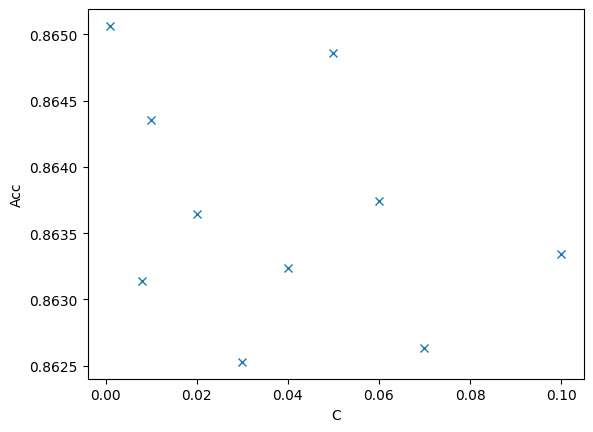

In [11]:
df_search = pd.DataFrame.from_dict(model1_gs.cv_results_)
plt.xlabel('C')
plt.ylabel('Acc')
_ = plt.plot(df_search['param_C'], df_search['mean_test_score'], 'x')
print('Best_parameter',model1_gs.best_params_, "\nAcc: {}".format(round(model1_gs.best_score_,3)))

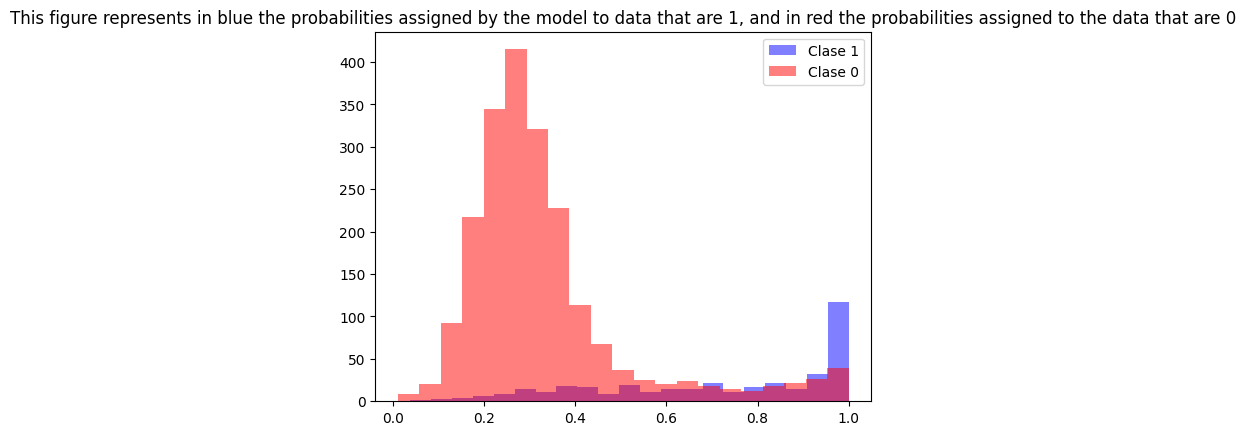

In [12]:
model1 = LogisticRegression(class_weight='balanced', C=model1_gs.best_params_.get("C"))
model1.fit(X_train, Y_train)
y_test_pred_prob = model1.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

def representation_seuil(x_1, x_0, n_bins=11, title='This figure represents in blue the probabilities assigned by the model to data that are 1, and in red the probabilities assigned to the data that are 0', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='blue')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='red')
    plt.title(title)
    plt.legend(loc='best') 
    
representation_seuil(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)    


In [13]:
THRESHOLD = 0.5
y_THRESHOLD = 1*(y_test_pred_prob[:, 1] > THRESHOLD)

print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_THRESHOLD))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_THRESHOLD),3)))  
print("Sensitivity\t{}".format(round(metrics.recall_score(Y_test, y_THRESHOLD),3)))
print(u"Precision\t{}".format(round(metrics.precision_score(Y_test, y_THRESHOLD),3))) 

Matriz de confusión
 [[1844  238]
 [  91  293]]

Accuracy	0.867
Sensitivity	0.763
Precision	0.552


In [14]:
THRESHOLD = 0.6
y_THRESHOLD = 1*(y_test_pred_prob[:, 1] > THRESHOLD)

print(u"Matrice de confusion\n", metrics.confusion_matrix(Y_test, y_THRESHOLD))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_THRESHOLD),3)))  
print("Sensitivity\t{}".format(round(metrics.recall_score(Y_test, y_THRESHOLD),3)))
print(u"Precision\t{}".format(round(metrics.precision_score(Y_test, y_THRESHOLD),3))) 

Matrice de confusion
 [[1900  182]
 [ 125  259]]

Accuracy	0.876
Sensitivity	0.674
Precision	0.587


In [15]:
THRESHOLD = 0.55
y_THRESHOLD = 1*(y_test_pred_prob[:, 1] > THRESHOLD)

print(u"Matrice de confusion\n", metrics.confusion_matrix(Y_test, y_THRESHOLD))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_THRESHOLD),3)))  
print("Sensitivity\t{}".format(round(metrics.recall_score(Y_test, y_THRESHOLD),3)))
print(u"Precision\t{}".format(round(metrics.precision_score(Y_test, y_THRESHOLD),3)))

Matrice de confusion
 [[1873  209]
 [ 112  272]]

Accuracy	0.87
Sensitivity	0.708
Precision	0.565


In [16]:
# We will keep the threshold of 0.55 which allows to have a good trade-off between accuracy and recall

Feature: Administrative Score: 0.02885713937723401
Feature: Administrative_Duration Score: -7.566327840390708e-06
Feature: Informational Score: 0.011753498684698957
Feature: Informational_Duration Score: -4.391179877101485e-05
Feature: ProductRelated Score: 0.003403229140850976
Feature: ProductRelated_Duration Score: 0.00010696625853802632
Feature: BounceRates Score: -0.006536826889379618
Feature: ExitRates Score: -0.009476670152546818
Feature: PageValues Score: 0.1156971903064263
Feature: SpecialDay Score: -0.0205103016614486
Feature: Month Score: 0.010259242955918391
Feature: OperatingSystems Score: -0.16897998672208936
Feature: Browser Score: -0.13281141807127536
Feature: Region Score: -0.11491142725370121
Feature: TrafficType Score: -0.017612804922017816
Feature: VisitorType Score: -0.06826741112511096
Feature: Weekend Score: -0.0016931805845384216


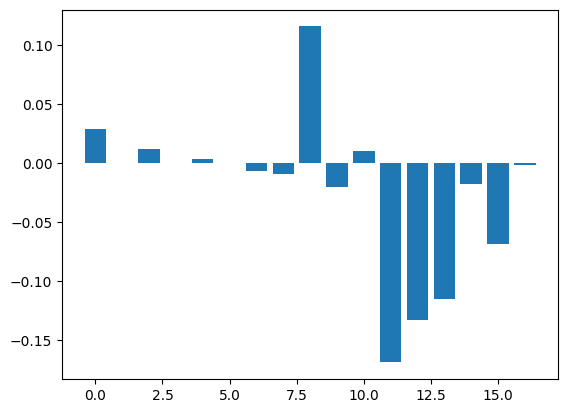

['PageValues', 'OperatingSystems', 'Browser', 'Region', 'VisitorType']

In [17]:
importance = model1.coef_[0]
important_features=[]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature:',df.columns[i],'Score:', v)
    if (v>0.04 or v<-0.04):
        important_features.append(df.columns[i])
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

important_features

In [19]:
df = pd.read_csv("/config/workspace/machine datasets/online_shoppers_intention.csv")
columns=important_features+['Revenue']
df_less_features=preprocessing(df,columns)
X_train, X_test, Y_train, Y_test=Split(df_less_features)

In [20]:
model1 = LogisticRegression(class_weight='balanced')
parametres = {"C": [0.001, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.1]}
model1_gs = GridSearchCV(model1, param_grid=parametres,
                         cv = 10, scoring='accuracy')
model1_gs.fit(X_train, Y_train)
print(model1_gs.best_params_, "\nAcc: {}".format(round(model1_gs.best_score_,3)))

{'C': 0.05} 
Acc: 0.89


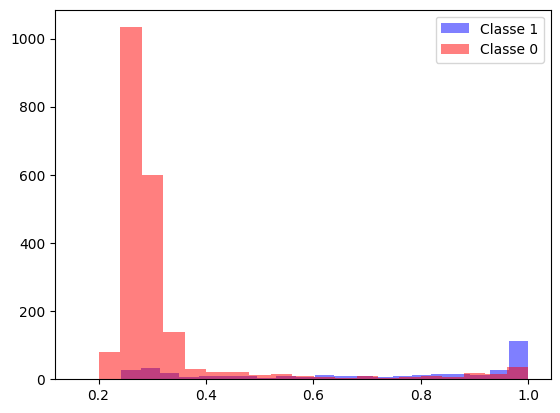

In [21]:
model1 = LogisticRegression(class_weight='balanced', C=model1_gs.best_params_.get("C"))
model1.fit(X_train, Y_train)
y_test_pred_prob = model1.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

def representation_seuil(x_1, x_0, n_bins=11, title='', label_1='Classe 1', 
                          label_0='Classe 0', density=0):
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='blue')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='red')
    plt.title(title)
    plt.legend(loc='best') 
    
representation_seuil(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)    

In [22]:
THRESHOLD = 0.6
y_threshold = 1*(y_test_pred_prob[:, 1] > THRESHOLD)

print(u"Matriz de confusion\n", metrics.confusion_matrix(Y_test, y_threshold))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_threshold),3)))  
print("Sensitivity\t{}".format(round(metrics.recall_score(Y_test, y_threshold),3)))
print(u"Precision\t{}".format(round(metrics.precision_score(Y_test, y_threshold),3)))

Matriz de confusion
 [[1962  120]
 [ 135  249]]

Accuracy	0.897
Sensitivity	0.648
Precision	0.675


In [23]:
THRESHOLD = 0.55
y_threshold = 1*(y_test_pred_prob[:, 1] > THRESHOLD)

print(u"Matriz de confusion\n", metrics.confusion_matrix(Y_test, y_threshold))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_threshold),3)))  
print("Sensitivity\t{}".format(round(metrics.recall_score(Y_test, y_threshold),3)))
print(u"Precision\t{}".format(round(metrics.precision_score(Y_test, y_threshold),3)))

Matriz de confusion
 [[1946  136]
 [ 123  261]]

Accuracy	0.895
Sensitivity	0.68
Precision	0.657


In [24]:
THRESHOLD = 0.5
y_threshold = 1*(y_test_pred_prob[:, 1] > THRESHOLD)

print(u"Matriz de confusion\n", metrics.confusion_matrix(Y_test, y_threshold))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_threshold),3)))  
print("Sensitivity\t{}".format(round(metrics.recall_score(Y_test, y_threshold),3)))
print(u"Precision\t{}".format(round(metrics.precision_score(Y_test, y_threshold),3)))

Matriz de confusion
 [[1930  152]
 [ 114  270]]

Accuracy	0.892
Sensitivity	0.703
Precision	0.64


In [25]:
# > > MODEL 2 RANDOM FOREST

In [26]:
model2 = RandomForestClassifier(n_estimators = 30,max_depth = 10,random_state = 101)
model2.fit(X_train,Y_train)
pred = model2.predict(X_test)
print('Results Random Forest with no optimization')
print(classification_report(Y_test,pred))
print(model2.score(X_test,Y_test))


Results Random Forest with no optimization
              precision    recall  f1-score   support

       False       0.92      0.95      0.94      2082
        True       0.67      0.57      0.61       384

    accuracy                           0.89      2466
   macro avg       0.80      0.76      0.77      2466
weighted avg       0.88      0.89      0.89      2466

0.8888888888888888


In [28]:
param_grid = {
    'n_estimators' : [60,100],
    'max_depth' : [10,15],
    'min_samples_leaf' : [2,4],
    'min_samples_split': [2,4]
}

gridsearch = GridSearchCV(estimator=model2,param_grid=param_grid,verbose = 1)
gridsearch.fit(X_train,Y_train)
gridsearch.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 60}

In [29]:
model2 = RandomForestClassifier(n_estimators = 60,max_depth = 10,min_samples_leaf = 3, min_samples_split = 2,random_state = 101)
model2.fit(X_train,Y_train)
pred = model2.predict(X_test)
print(classification_report(Y_test,pred))

from sklearn.metrics import accuracy_score
Acc = accuracy_score(Y_test,pred)
print('Accuracy',Acc)

              precision    recall  f1-score   support

       False       0.92      0.95      0.94      2082
        True       0.67      0.57      0.61       384

    accuracy                           0.89      2466
   macro avg       0.80      0.76      0.77      2466
weighted avg       0.88      0.89      0.89      2466

Accuracy 0.889294403892944


In [ ]:
# Results

# We thus obtain in our best logistic regression model: 0.91 accuracy, 0.62 recall.
# The logistic regression is finally a better model than random forest to predict shopping intentions